#### Importing frameworks ####

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
import lightgbm as lgb
from scipy.stats import probplot
import xgboost as xgb
from typing import Union
import math
import pickle
import joblib
import warnings
import wrmsse_eval
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.2f}'.format)
from IPython.display import Image

#### General functions ####

In [97]:
days_val = [f'd_{i}' for i in range(1914, 1942)]
model_metrics = {}

In [98]:
def add_model_metric(model_name, wrmsse):
    model_metrics[model_name] = wrmsse

In [101]:
def analyze_residuals(sales_eval_df, pred_df, days = days_val):
    actual_values = sales_eval_df[days].iloc[0].values
    predicted_values = pred_df[days].iloc[0].values
    residuals = actual_values - predicted_values

    # Histogram of Residuals
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True, bins=20)
    plt.xlabel('Residuals')
    plt.title('Histogram of Residuals')
    plt.grid(True)
    plt.show()

    # ACF Plot of Residuals
    plt.figure(figsize=(12, 6))
    sm.graphics.tsa.plot_acf(residuals, lags=20)
    plt.title('Autocorrelation Function (ACF) of Residuals')
    plt.show()

    # QQ Plot of Residuals
    plt.figure(figsize=(12, 6))
    sm.qqplot(residuals, line='s')
    plt.title('QQ Plot of Residuals')
    plt.show()


In [95]:
def plot_actual_vs_predicted(sales_eval_df, sgd_pred_df, days = days_val):
    actual_values = sales_eval_df[days].iloc[0].values
    predicted_values = sgd_pred_df[days].iloc[0].values

    plt.figure(figsize=(12, 6))
    plt.plot(days, actual_values, label='Actual', marker='o')
    plt.plot(days, predicted_values, label='Predicted', marker='x')
    plt.xlabel('Days')
    plt.ylabel('Sales')
    plt.title('Actual vs Predicted Sales')
    plt.legend()
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

In [109]:
def display_model_metrics(metrics_dict):
    # Convert dictionary to DataFrame
    metrics_df = pd.DataFrame(list(metrics_dict.items()), columns=['Model Name', 'WRMSSE'])
    return metrics_df

#### Load data ####

In [3]:
calendar_df = pd.read_csv('./data/input/calendar.csv')
sales_df = pd.read_csv('./data/input/sales_train_validation.csv')
prices_df = pd.read_csv('./data/input/sell_prices.csv')
sales_eval_df = pd.read_csv('./data/input/sales_train_evaluation.csv') #reading eval data since we have true labels for days from 1914 till 1941

In [4]:
print('shape of calendar_df',calendar_df.shape)
print('top rows of calendar_df')
calendar_df.head()

shape of calendar_df (1969, 14)
top rows of calendar_df


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
print('shape of sales_df',sales_df.shape)
print('top rows of sales_df')
sales_df.head()

shape of sales_df (30490, 1919)
top rows of sales_df


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:
print('shape of prices_df',prices_df.shape)
print('top rows of prices_df')
prices_df.head()

shape of prices_df (6841121, 4)
top rows of prices_df


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [7]:
#reference: https://www.kaggle.com/kyakovlev/m5-simple-fe
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

#### Feature engineering ####

Here we are inserting the columns for validation set from days d_1914 to d_1941 which we need to forecast sales as nan

In [8]:
for i in range(1914,1942):
    sales_df['d_'+str(i)] = np.nan
    sales_df['d_'+str(i)] = sales_df['d_'+str(i)].astype(np.float16)


In [9]:
#to reduce the memory usage by changing the dtypes of columns of the dataframes
calendar_df = reduce_mem_usage(calendar_df)
prices_df = reduce_mem_usage(prices_df)
sales_df = reduce_mem_usage(sales_df)

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 101.51 Mb (77.3% reduction)


Transform the dataframe into vertical rows as each corresponds to each day sales of an item from a particular store

In [10]:
sales_melt_df = pd.melt(sales_df, id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],
                       var_name='d',value_name='sales')

Changing the dtype of object to category in order to reduce the size of dataframe

In [11]:
for col in sales_melt_df.columns[:6]:
    sales_melt_df[col] = sales_melt_df[col].astype('category')

In [12]:
#creating a single dataframe
sales_melt_df = sales_melt_df.merge(calendar_df,  on='d', how='left')
sales_melt_df = sales_melt_df.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')

In this work I will use filling missing sell_price values by mean

In [13]:
sales_melt_df['sell_price'].fillna(sales_melt_df.groupby('id')['sell_price'].transform('mean'),inplace=True)

In this work we will use the creation of functions of the following types:

- lag fetures 
- rolling features
- date time features

##### Lag features #####

The lag features approach  help capture the sales patterns over different weeks leading up to the forecast period.
In this work we will use approach that generates a new lag feature (lag_n) by shifting the sales data by an additional 7 days (1 week) on top of the initial 28 days in each iteration.

In [14]:
shifting = 28 
for i in tqdm(range(9)): 
    sales_melt_df['lag_'+str(shifting+(7*i))] = sales_melt_df.groupby('id')['sales'].shift(shifting+(7*i)).astype(np.float16)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.74it/s]


##### Rolling features #####

These rolling statistics help capture trends and central tendencies over various time windows, enhancing the forecasting model by incorporating short-term and long-term patterns.
We will use the list [7, 14, 28, 35, 60], which represents different periods for the rolling window.
For each period i, the code calculates the rolling mean and rolling median of the lag_28 column within each group of id.

In [15]:
for i in tqdm([7,14,28,35,60]):
    sales_melt_df['rolling_mean_'+str(i)] =  sales_melt_df.groupby(['id'])['lag_28'].transform(lambda x: x.rolling(i).mean())
    sales_melt_df['rolling_median_'+str(i)] =  sales_melt_df.groupby(['id'])['lag_28'].transform(lambda x: x.rolling(i).median())


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:40<00:00, 32.09s/it]


##### Date Time Features #####

We will use the date  time functions

In [16]:
#changing dtype of calender features to category
cal_cols = ['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']
for col in cal_cols:
    sales_melt_df[col] = sales_melt_df[col].astype('category')

In [17]:
sales_melt_df['date'] = pd.to_datetime(sales_melt_df['date'])
#each day of the month
sales_melt_df['day_of_month'] = sales_melt_df['date'].dt.day.astype(np.int8)
#changing year value as 0 for 2011 and 1 for 2012
sales_melt_df['year'] = (sales_melt_df['year'] - sales_melt_df['year'].min()).astype(np.int8)
#week number of a day in a month ex: 29th in January corresponds to 5th week of January
sales_melt_df['week_no_inmonth'] = sales_melt_df['day_of_month'].apply(lambda x: math.ceil(x/7)).astype(np.int8)
#checking if the day is weekend or not
sales_melt_df['is_weekend'] = (sales_melt_df['wday']<=2).astype(np.int8)

In [18]:
sales_melt_df.to_pickle("sales_melt_calfadd_df") #store the final feature engineered dataframe to disk

In [19]:
sales_melt_df = pd.read_pickle("sales_melt_calfadd_df")

In [20]:
sales_melt_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,rolling_median_14,rolling_mean_28,rolling_median_28,rolling_mean_35,rolling_median_35,rolling_mean_60,rolling_median_60,day_of_month,week_no_inmonth,is_weekend
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.00,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,5,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.00,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,5,1
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.00,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,5,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.00,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,5,1
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.00,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,5,1


In [21]:
#changing the dtype to category for these columns in order to process the columns with label encoding
cat_cols = ['id','item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2','snap_CA','snap_TX','snap_WI']
for col in cat_cols:
    sales_melt_df[col] = sales_melt_df[col].astype('category')

In [22]:
#method which return the label encoded columns
def label_encoding(df,cols):
    for col in cols:
        lenc = LabelEncoder()
        df[col] = lenc.fit_transform(df[col].astype(str))
    return df

In [23]:
df_enc = label_encoding(sales_melt_df,cat_cols) #transforming the categorical columns to label encoded columns
df_enc['d'] = df_enc['d'].apply(lambda x: x.split('_')[1]).astype(np.int16) #splitting the values of 'd' comlumn to take only the day number

In [24]:
#final dataframe after pre-processing and feature engineering we are taking last  year data to train the ML model
df_final = df_enc.loc[pd.to_datetime(df_enc['date'].dt.date) >= '2015-05-22']
df_final.shape

(11189830, 44)

#### Splitting data ####

In [25]:
df_final.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,rolling_median_14,rolling_mean_28,rolling_median_28,rolling_mean_35,rolling_median_35,rolling_mean_60,rolling_median_60,day_of_month,week_no_inmonth,is_weekend
47991260,14370,1437,3,1,0,0,1575,0.00,2015-05-22,11516,...,0.50,0.75,1.00,0.83,1.00,0.78,1.00,22,4,0
47991261,14380,1438,3,1,0,0,1575,0.00,2015-05-22,11516,...,0.00,0.07,0.00,0.09,0.00,0.12,0.00,22,4,0


In [26]:
train_end = 1885 #end of training
X_train = df_final[df_final['d'] <= train_end].drop(['sales','date','weekday','wm_yr_wk'],axis=1)
y_train = df_final[df_final['d'] <= train_end]['sales']

X_val = df_final[(df_final['d'] > train_end) & (df_final['d'] <= train_end+28)].drop(['sales','date','weekday','wm_yr_wk'],axis=1)
y_val = df_final[(df_final['d'] > train_end) & (df_final['d'] <= train_end+28)]['sales']

X_test = df_final[(df_final['d'] > train_end+28)].drop(['sales','date','weekday','wm_yr_wk'],axis=1)


In [27]:
X_train.shape, X_val.shape, X_test.shape

((9482390, 40), (853720, 40), (853720, 40))

In [28]:
#storing the train,cv, test dataframes
X_train.to_pickle('./data_preprocessed/X_train')
y_train.to_pickle('./data_preprocessed/y_train')
X_val.to_pickle('./data_preprocessed/X_val')
y_val.to_pickle('./data_preprocessed/y_val')
X_test.to_pickle('./data_preprocessed/X_test')

In [30]:
#group into 12-level hierarchical time series to calculate WRMSSE 
groups_agg = ('for_all', 'state_id', 'store_id', 'cat_id', 'dept_id',['state_id', 'cat_id'],  
            ['state_id', 'dept_id'], ['store_id', 'cat_id'],['store_id', 'dept_id'], 'item_id', 
            ['item_id', 'state_id'], ['item_id', 'store_id'])

In [31]:
#loading the train,cv, test dataframes
X_train = pd.read_pickle("./data_preprocessed/X_train")
y_train = pd.read_pickle("./data_preprocessed/y_train")
X_val = pd.read_pickle("./data_preprocessed/X_val")
y_val = pd.read_pickle("./data_preprocessed/y_val")
X_test = pd.read_pickle("./data_preprocessed/X_test")

We use data from d_1575 because how was mentioned previosly we will use data from 2015-05-22

In [32]:
prep_df = pd.concat([sales_eval_df.loc[:,:'state_id'],sales_eval_df.loc[:,'d_1575':]],axis=1,sort=False)
train_df = prep_df.iloc[:,:-28]
valid_df = prep_df.iloc[:,-28:].copy()

In [50]:
train_d_cols = [col for col in train_df.columns if col.startswith('d_')]
weight_cols = train_df.iloc[:,-28:].columns.tolist()
train_df['for_all'] = "all" #for level 1 aggregation
fixed_cols = [col for col in train_df.columns if not col.startswith('d_')]
valid_d_cols = [col for col in valid_df.columns if col.startswith('d_')]
if not all([col in valid_df.columns for col in fixed_cols]):
    valid_df = pd.concat([train_df[fixed_cols],valid_df],axis=1,sort=False)

In [34]:
weight_cols

['d_1886',
 'd_1887',
 'd_1888',
 'd_1889',
 'd_1890',
 'd_1891',
 'd_1892',
 'd_1893',
 'd_1894',
 'd_1895',
 'd_1896',
 'd_1897',
 'd_1898',
 'd_1899',
 'd_1900',
 'd_1901',
 'd_1902',
 'd_1903',
 'd_1904',
 'd_1905',
 'd_1906',
 'd_1907',
 'd_1908',
 'd_1909',
 'd_1910',
 'd_1911',
 'd_1912',
 'd_1913']

In [35]:
#weights corresponding all the 12-level hierarchical transformed 42840 time-series
weight_df = wrmsse_eval.compute_weights(train_df,valid_df, weight_cols,groups_agg,fixed_cols,calendar_df,prices_df)
#train data transformed from 30490 timeseries to 42840 hirerachichal time-series
train_42840_df = wrmsse_eval.convert_to_42840(train_df, train_d_cols, groups_agg)
#validation data transformed from 30490 timeseries to 42840 hirerachichal time-series
valid_42840_df = wrmsse_eval.convert_to_42840(valid_df, valid_d_cols, groups_agg)

#### Naive forecast ####

In [115]:
non_d_cols = ['id','item_id','dept_id','cat_id','store_id','state_id','for_all']
d_cols = [col for col in train_df.columns if col.startswith('d_')]

In [116]:
groupbys = ('for_all', 'state_id', 'store_id', 'cat_id', 'dept_id',['state_id', 'cat_id'],  
            ['state_id', 'dept_id'], ['store_id', 'cat_id'],['store_id', 'dept_id'], 'item_id', 
            ['item_id', 'state_id'], ['item_id', 'store_id'])
train_df = sales_eval_df.iloc[:,:-28]
valid_df = sales_eval_df.iloc[:,-28:].copy()
train_d_cols = [col for col in train_df.columns if col.startswith('d_')]
weight_cols = train_df.iloc[:,-28:].columns.tolist()
train_df['for_all'] = "all" #for level 1 aggregation
fixed_cols = [col for col in train_df.columns if not col.startswith('d_')]
valid_d_cols = [col for col in valid_df.columns if col.startswith('d_')]
if not all([col in valid_df.columns for col in fixed_cols]):
    valid_df = pd.concat([train_df[fixed_cols],valid_df],axis=1,sort=False)
weight_df = wrmsse_eval.compute_weights(train_df,valid_df,weight_cols,groups_agg,fixed_cols,calendar_df,prices_df)

In [117]:
pred_ser = []
last_28_days = d_cols[-28:]
for i in tqdm(range(len(train_df))):
    tmp_df = train_df.iloc[[i]]
    tmp_df = tmp_df.loc[:,last_28_days].T.reset_index().rename(columns={i:'sales'})
    avg_dict = {}
    pred_lst = []
    for j in range(7):
        tmp_lst = []
        for n in range(0+j,28,7):
            tmp_lst.append(n)
        avg_dict[j] = tmp_df.iloc[tmp_lst]['sales'].mean()
    for p in range(1914,1942):
        pred_lst.append(avg_dict[(p-1914)%7])
    pred_ser.append(pred_lst)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30490/30490 [00:23<00:00, 1287.16it/s]


In [118]:
train_42840_df = wrmsse_eval.convert_to_42840(train_df, train_d_cols, groups_agg)
valid_42840_df = wrmsse_eval.convert_to_42840(valid_df, valid_d_cols, groups_agg)
predictions = np.asarray(pred_ser)
if isinstance(predictions, np.ndarray):
    predictions = pd.DataFrame(predictions, columns=valid_d_cols)
predictions = pd.concat([valid_df[fixed_cols], predictions],axis=1,sort=False)
pred_42840_df = wrmsse_eval.convert_to_42840(predictions,valid_d_cols,groups_agg)

In [119]:
WRMSSE = wrmsse_eval.calculate_wrmsse_score(train_42840_df,valid_42840_df,pred_42840_df,weight_df)

WRMSSE of the model forecasted sales, as the mean sales for the past 4 weeks of that dayofweek  0.7524201372210837


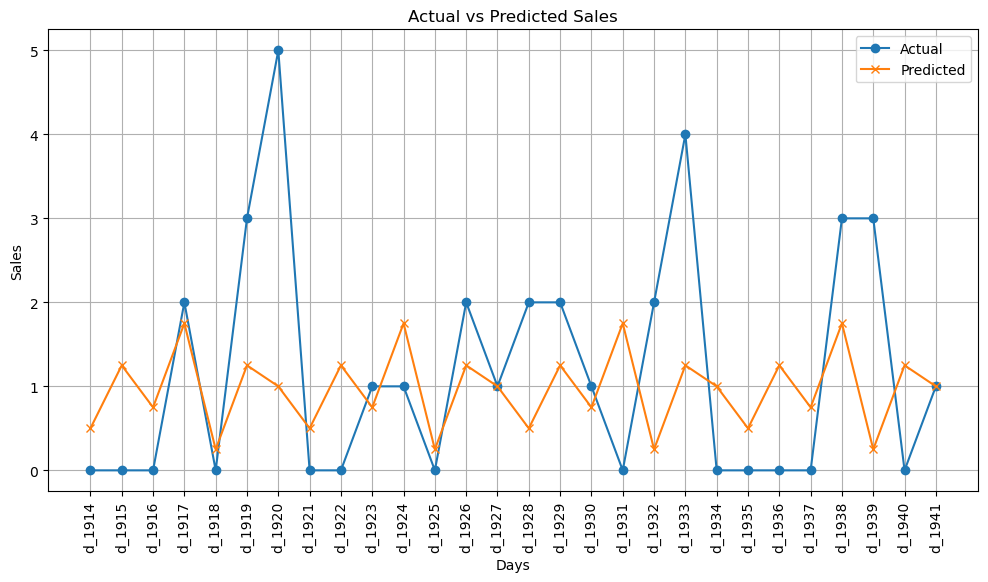

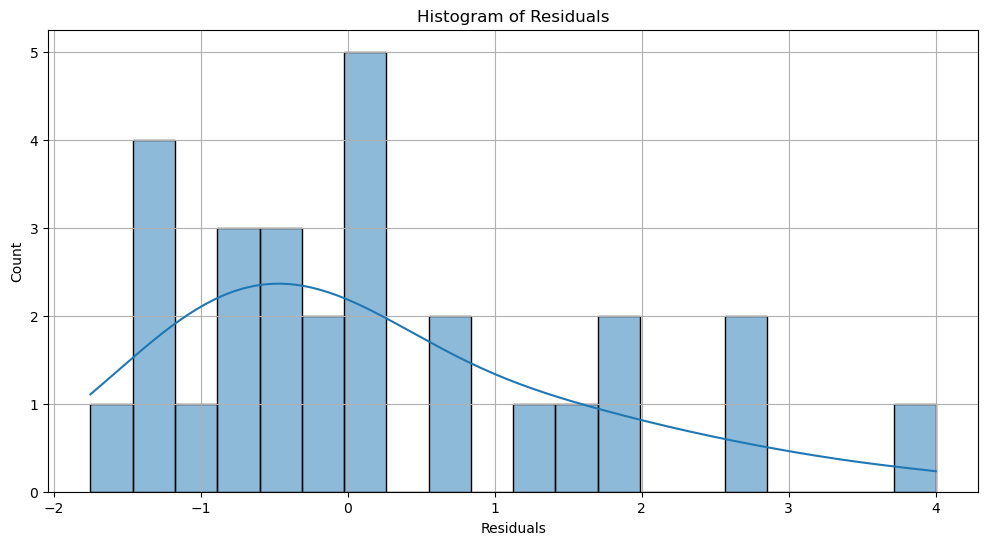

<Figure size 1200x600 with 0 Axes>

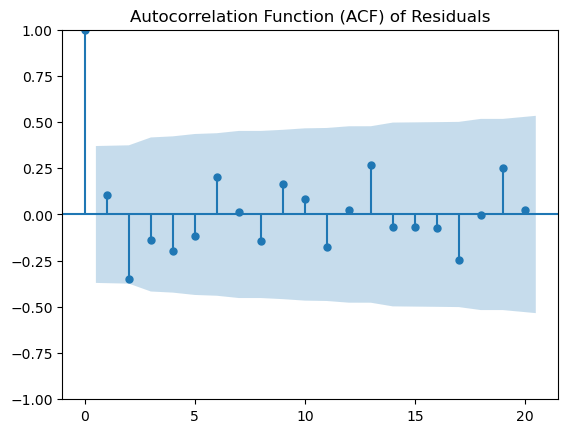

<Figure size 1200x600 with 0 Axes>

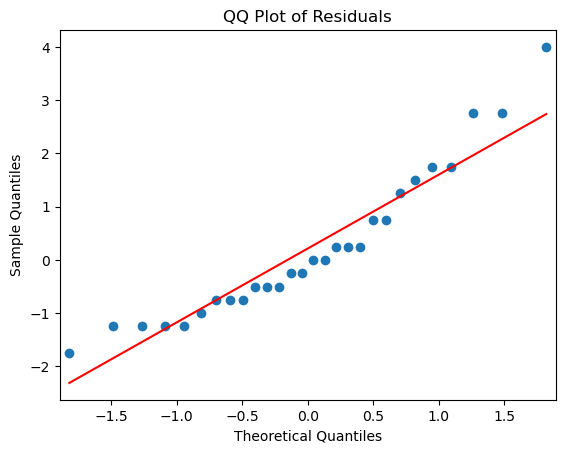

In [128]:
print("WRMSSE of the model forecasted sales, as the mean sales for the past 4 weeks of that dayofweek ",WRMSSE)
model_metrics["Naive model"] =  WRMSSE 

""" As we can see, we see a good capture of the pattern by our model. Some drops and ups are repeated. 
    
    Let's check the residuals 

    ACF: as we can see, we have no significant lags for the residuals. And the QQ plots look pretty good, showing that the model is almost catching the pattern.
    But our residuals do not have a normal distribution and are positively skewed to the left """



plot_actual_vs_predicted(sales_eval_df, predictions)
analyze_residuals(sales_eval_df, predictions)

In [42]:
submit_val = predictions[['id']]
for i in range(28):
    submit_val['F'+str(i+1)] = predictions['d_'+str(1914+i)]
submit_val['id'] =  submit_val['id'].apply(lambda x: x.replace('evaluation','validation'))
submit_eval = submit_val.copy()
submit_eval["id"] = submit_eval["id"].apply(lambda x: x.replace('validation','evaluation'))
naive_predictions = pd.concat([submit_val, submit_eval], ignore_index=True)

In [43]:
naive_predictions.to_csv("naive_predictions.csv", index=False,encoding='utf-8', quoting=1)

#### MA baseline model ####

In [53]:
train_df = train_df[non_d_cols+d_cols]

In [45]:
def moving_average(df, alpha):
    ma_predictions = []
    n = -alpha
    f_days = 28

    # Isolate the time series data columns
    time_series_columns = [col for col in df.columns if col.startswith('d_')]

    for j in tqdm(range(len(df))):
        tmp_df = df.iloc[[j]][time_series_columns]
        pred_lst = []
        for i in range(f_days):
            win = n + i
            if win >= 0:
                pred_lst.append(tmp_df.iloc[:, win:].T.mean().values)
            else:
                pred_lst.append(tmp_df.T.mean().values)  # Use the mean of the entire series for the initial values
        pred_lst = [float(i) for i in pred_lst]
        ma_predictions.append(pred_lst)
    return np.asarray(ma_predictions).reshape(30490,28)


In [54]:
WRMSSE_MA = {}
train_42840_df = wrmsse_eval.convert_to_42840(train_df, train_d_cols, groups_agg)
valid_42840_df = wrmsse_eval.convert_to_42840(valid_df, valid_d_cols, groups_agg)



In [59]:
ma_predictions = moving_average(train_df,28)
if isinstance(ma_predictions, np.ndarray):
    ma_predictions = pd.DataFrame(ma_predictions, columns=valid_d_cols)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30490/30490 [02:19<00:00, 219.10it/s]


In [60]:
ma_predictions = pd.concat([valid_df[fixed_cols], ma_predictions],axis=1,sort=False)

pred_42840_df =  wrmsse_eval.convert_to_42840(ma_predictions,valid_d_cols,groups_agg)
WRMSSE =  wrmsse_eval.calculate_wrmsse_score(train_42840_df,valid_42840_df,pred_42840_df,weight_df)
WRMSSE_MA[28] = WRMSSE

In [61]:
# Accessing and printing the WRMSSE value for the key 28
wrmsse_value = WRMSSE_MA.get(28, None)
if wrmsse_value is not None:
    print(f"WRMSSE value for MA model with alpha 28: {wrmsse_value}")
else:
    print("WRMSSE value for the specified key not found.")

WRMSSE value for MA model with alpha 28: 1.6917544702711833


In [113]:
add_model_metric("MA model", wrmsse_value)

In [63]:
submit_val = ma_predictions[['id']]
for i in range(28):
    submit_val['F'+str(i+1)] = ma_predictions['d_'+str(1914+i)]
submit_val['id'] =  submit_val['id'].apply(lambda x: x.replace('evaluation','validation'))
submit_eval = submit_val.copy()
submit_eval["id"] = submit_eval["id"].apply(lambda x: x.replace('validation','evaluation'))
moving_average_predictions = pd.concat([submit_val, submit_eval], ignore_index=True)
moving_average_predictions.to_csv("moving_average_predictions.csv", index=False, encoding='utf-8', quoting=1)

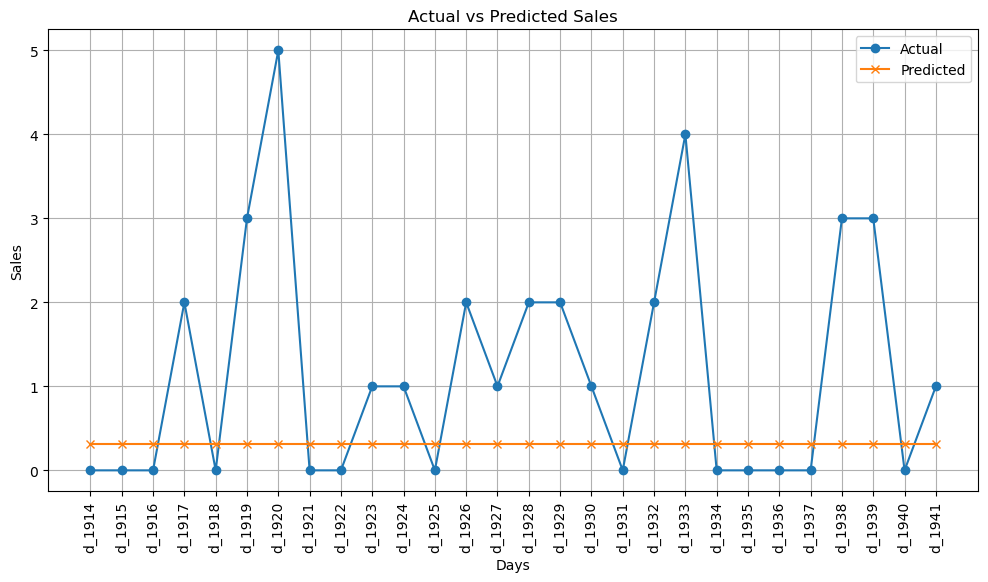

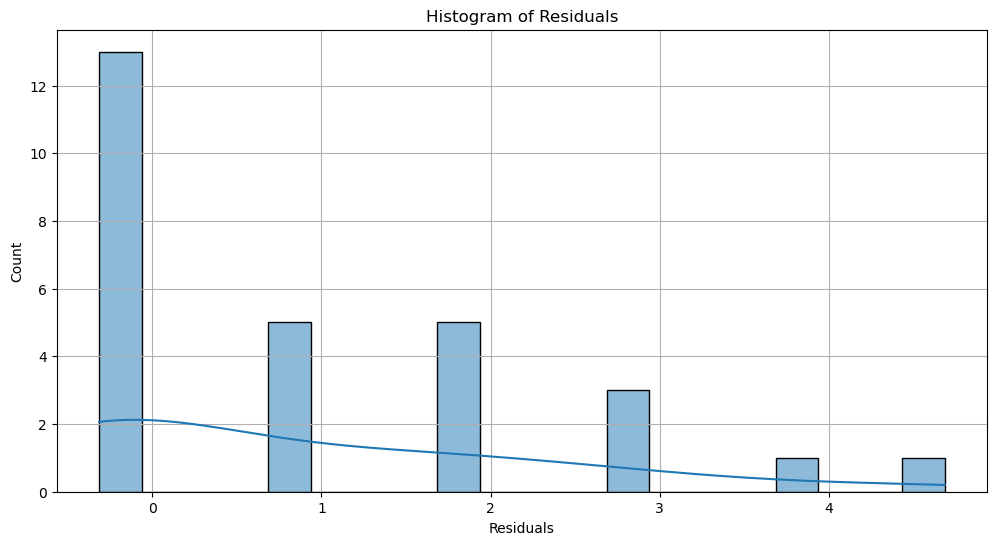

<Figure size 1200x600 with 0 Axes>

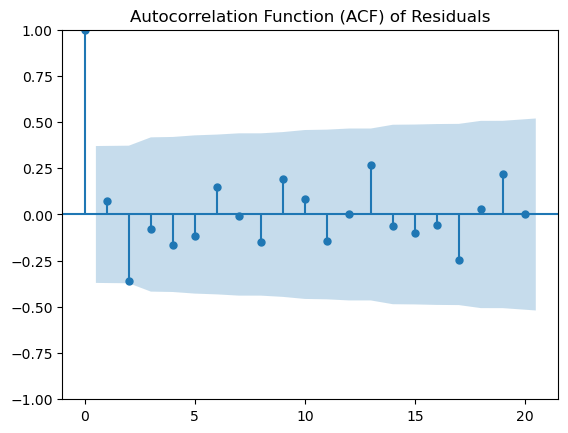

<Figure size 1200x600 with 0 Axes>

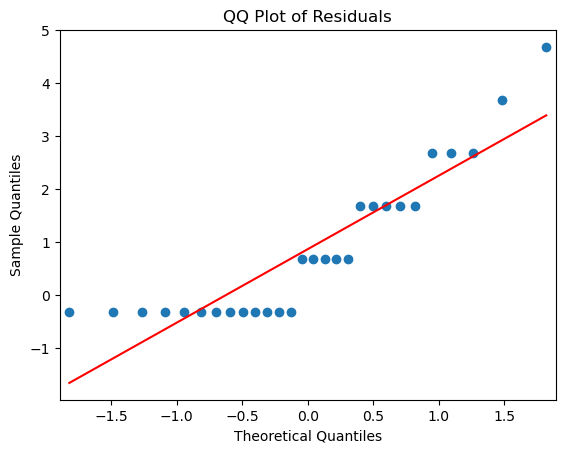

In [129]:
""" Analyze Residuals
    ACF: as we see we dont have significant lags of resiaduals. And the QQ plots do not look good enough, showing that the model has not captured the pattern and the residuals are not linearly distributed.
    But our residuals do not have a normal distribution and have a sharp positive skew to the left """



plot_actual_vs_predicted(sales_eval_df, ma_predictions)
analyze_residuals(sales_eval_df, ma_predictions)

####  SGDRegressor ####

In [64]:
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_val_scaled = scalar.fit_transform(X_val)
X_test_scaled = scalar.fit_transform(X_test)

In [65]:
sgd_alpha = 0.1
sgdreg = SGDRegressor(alpha=sgd_alpha,loss='squared_loss',early_stopping=True)
sgdreg.fit(X_train_scaled,y_train.values)
sgd_predictions = sgdreg.predict(X_test_scaled)

In [66]:
#slicing the predictions such that to get each day predictions of all the products of test data
start = 0
t = int(X_test.iloc[0]['d'])
sgd_pred_df = pd.DataFrame()
while start < len(sgd_predictions):
    end = start + 30490
    sgd_pred_df['d_'+str(t)] = sgd_predictions[start:end]
    start = end
    t = t+1
sgd_pred_df = pd.concat([valid_df[fixed_cols], sgd_pred_df],axis=1,sort=False)

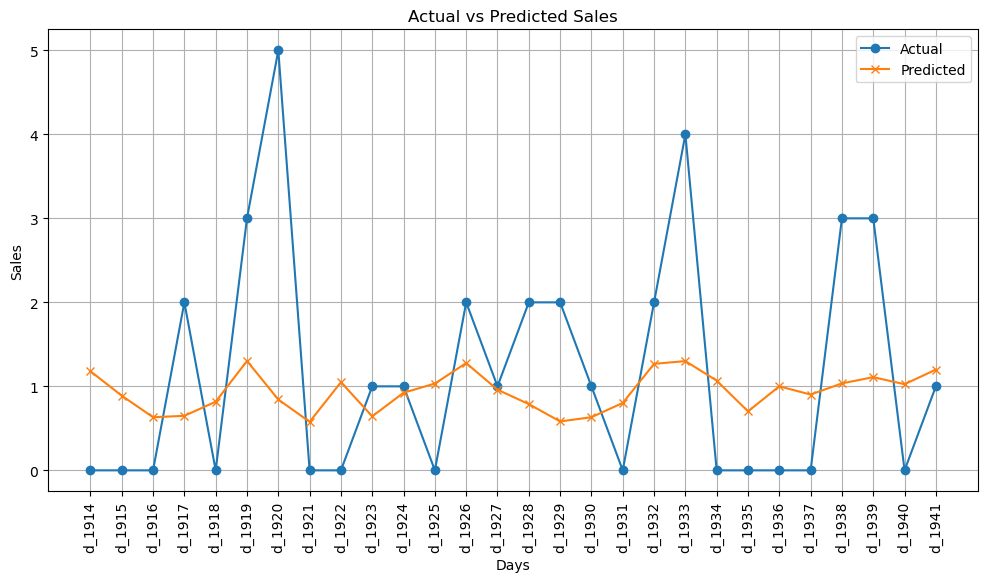

In [102]:
plot_actual_vs_predicted(sales_eval_df, sgd_pred_df)

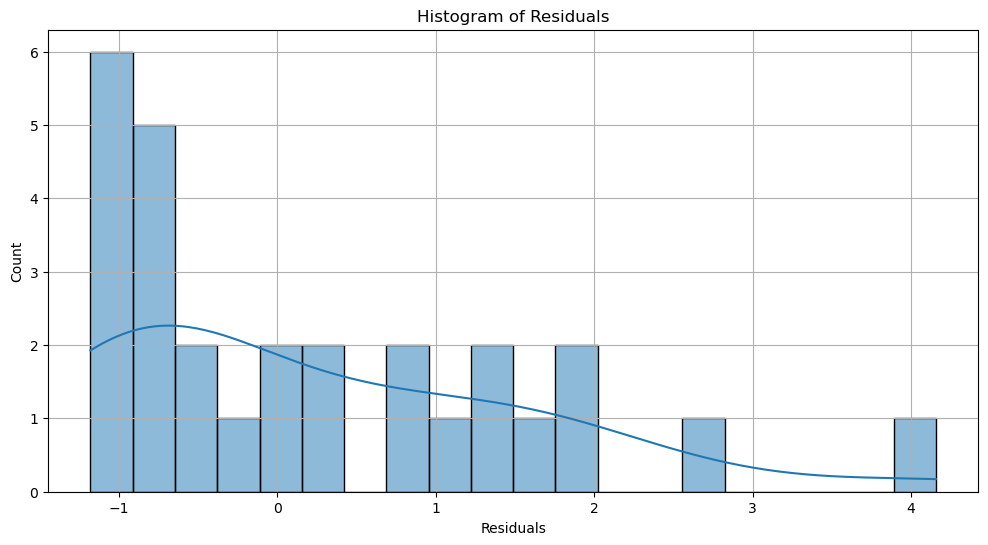

<Figure size 1200x600 with 0 Axes>

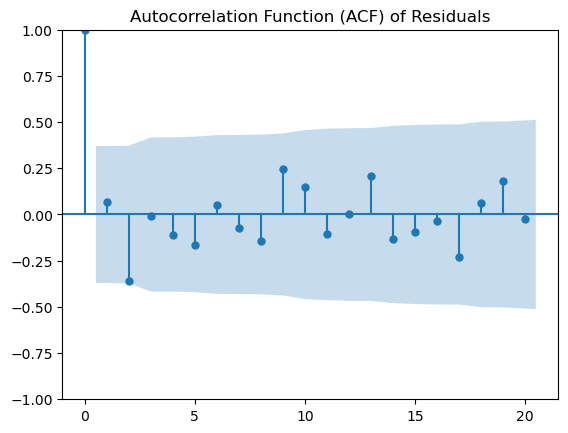

<Figure size 1200x600 with 0 Axes>

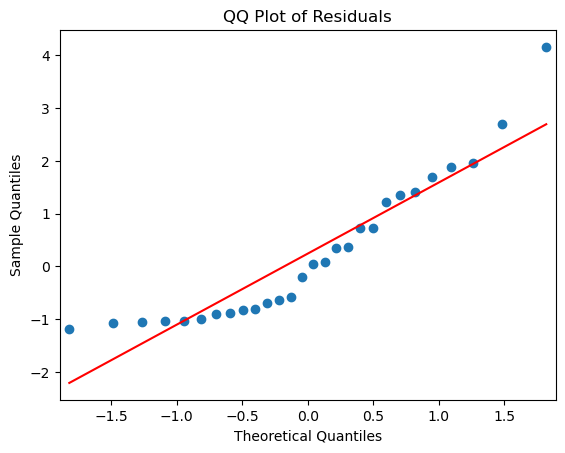

In [127]:
""" As we can see the actual data has more marked peaks. 
    Let's check residuals 

    ACF: as we see we dont have significant lags of resiaduals. And QQ plots looks quite good by showing that sgd model almost capture pattern.
    But our residuals do not have a normal distribution and with a sharp positive skew to the left """

analyze_residuals(sales_eval_df, sgd_pred_df)

In [67]:
#prediction data transformed from 30490 timeseries to 42840 hirerachichal time-series
pred_42840_df = wrmsse_eval.convert_to_42840(sgd_pred_df,valid_d_cols,groups_agg)
#Computed WRMSSE for each predictions based 
WRMSSE_sgd_te = wrmsse_eval.calculate_wrmsse_score(train_42840_df,valid_42840_df,pred_42840_df,weight_df)

In [110]:
print('WRMSSE on test data using SGDRegressor is: ',WRMSSE_sgd_te)
add_model_metric("SGD", WRMSSE_sgd_te)

WRMSSE on test data using SGDRegressor is:  0.9627256298630924


In [69]:
joblib.dump(sgdreg,'sgdreg.pkl') #store the sgd model

['sgdreg.pkl']

In [70]:
sgd_pred_df.to_csv('final_predictions_sgd.csv',index=False, encoding='utf-8', quoting=1)

In [71]:
final_predictions_sgd = pd.read_csv('final_predictions_sgd.csv')

In [72]:
submit_val = final_predictions_sgd[['id']]
for i in range(28):
    submit_val['F'+str(i+1)] = final_predictions_sgd['d_'+str(1914+i)]
submit_val['id'] =  submit_val['id'].apply(lambda x: x.replace('evaluation','validation'))
submit_eval = submit_val.copy()
submit_eval["id"] = submit_eval["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_sgd = pd.concat([submit_val, submit_eval], ignore_index=True)

In [73]:
submit_sgd.to_csv("submit_sgd_reg.csv", index=False, encoding='utf-8', quoting=1)

#### LGBMRegressor ####

In [74]:
alpha = 125
lr = 0.075
final_predictions_lgb = pd.DataFrame()
lgb_reg_best = lgb.LGBMRegressor(num_leaves=alpha,n_estimators=100,learning_rate=lr,n_jobs=-1)

In [75]:
lgb_reg_best.fit(X_train,y_train) #fit the model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.486117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3565
[LightGBM] [Info] Number of data points in the train set: 9482390, number of used features: 40
[LightGBM] [Info] Start training from score 1.291518


LGBMRegressor(learning_rate=0.075, n_jobs=-1, num_leaves=125)

In [76]:
#forecasting sales for the test data from day 1914 to 1941 test data
for i in range(1914,1942):
    final_predictions_lgb['d_'+str(i)] = lgb_reg_best.predict(X_test[X_test['d']==i])


In [77]:
# Remove fixed columns from final_predictions_lgb if they exist
final_predictions_lgb = final_predictions_lgb.drop(columns=fixed_cols, errors='ignore')

final_predictions_lgb = pd.concat([valid_df[fixed_cols], final_predictions_lgb],axis=1,sort=False)


In [78]:
pred_42840_df = wrmsse_eval.convert_to_42840(final_predictions_lgb,valid_d_cols,groups_agg)
#WRMSSE of test data
WRMSSE_lgb_test = wrmsse_eval.calculate_wrmsse_score(train_42840_df,valid_42840_df,pred_42840_df,weight_df)

In [111]:
print('WRMSSE on test data using lgbmregressor is: ',WRMSSE_lgb_test)
add_model_metric("LGBMRegressor", WRMSSE_lgb_test)

WRMSSE on test data using lgbmregressor is:  0.6665736100883195


In [80]:
joblib.dump(lgb_reg_best,'lgb_reg_best.pkl') #store the best model

['lgb_reg_best.pkl']

In [81]:
lgb_reg_best = joblib.load('lgb_reg_best.pkl')

In [82]:
final_predictions_lgb.to_csv('final_predictions_lgb.csv',index=False, encoding='utf-8', quoting=1)

In [83]:
#forecasted sales from from day 1914 till 1941 test data
final_predictions_lgb = pd.read_csv('final_predictions_lgb.csv')
final_predictions_lgb.head()

,id,item_id,dept_id,cat_id,store_id,state_id,for_all,d_1914,d_1915,d_1916,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,all,1.01,0.86,0.84,...,0.88,1.36,1.22,0.98,0.90,0.89,1.03,0.93,1.22,1.22
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,all,0.37,0.30,0.30,...,0.23,0.32,0.31,0.23,0.18,0.21,0.19,0.22,0.33,0.33
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,all,0.42,0.38,0.37,...,0.52,0.66,0.79,0.71,0.66,0.68,0.55,0.61,0.81,0.89
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,all,2.05,1.78,1.73,...,1.67,2.04,2.22,1.82,1.62,1.52,1.53,1.72,2.65,2.47
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,all,0.98,0.92,1.03,...,1.13,1.36,1.36,0.97,0.94,0.94,1.01,1.10,1.43,1.65


In [84]:
submit_val = final_predictions_lgb[['id']]
for i in range(28):
    submit_val['F'+str(i+1)] = final_predictions_lgb['d_'+str(1914+i)]
submit_val['id'] =  submit_val['id'].apply(lambda x: x.replace('evaluation','validation'))
submit_eval = submit_val.copy()
submit_eval["id"] = submit_eval["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_lgb = pd.concat([submit_val, submit_eval], ignore_index=True)


In [85]:
submit_lgb.to_csv("submit_lgb.csv", index=False, encoding='utf-8', quoting=1)

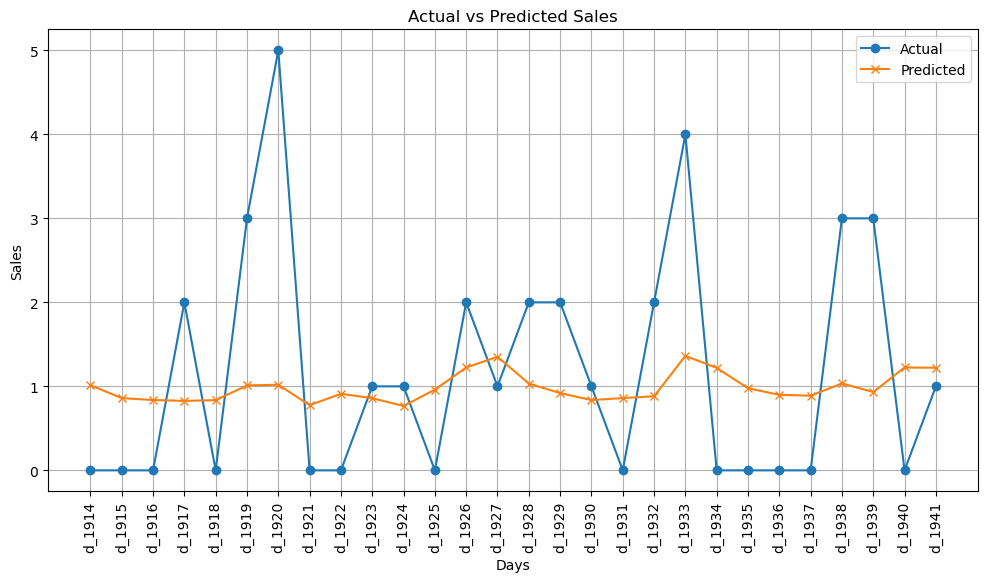

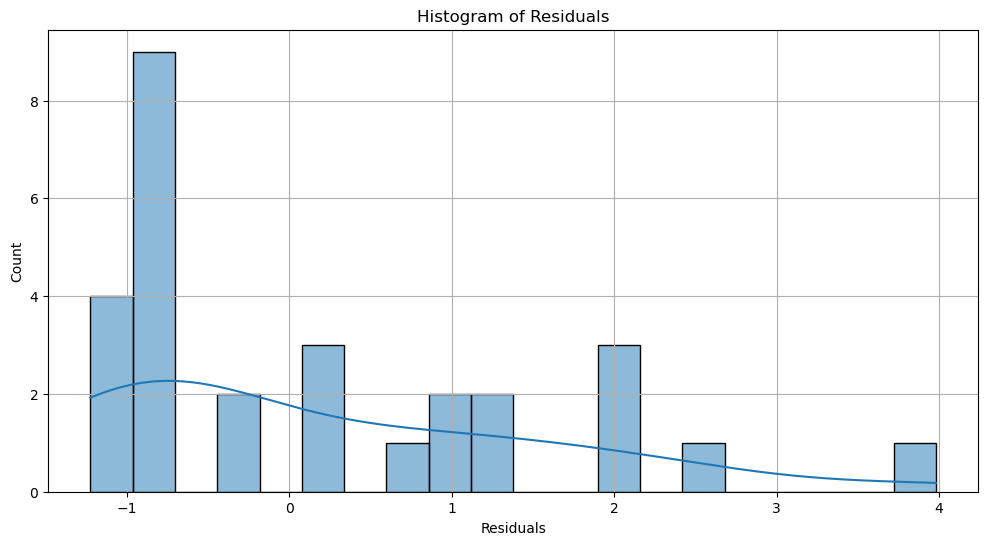

<Figure size 1200x600 with 0 Axes>

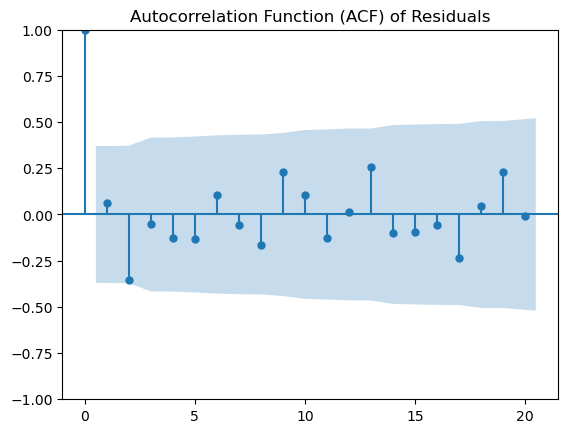

<Figure size 1200x600 with 0 Axes>

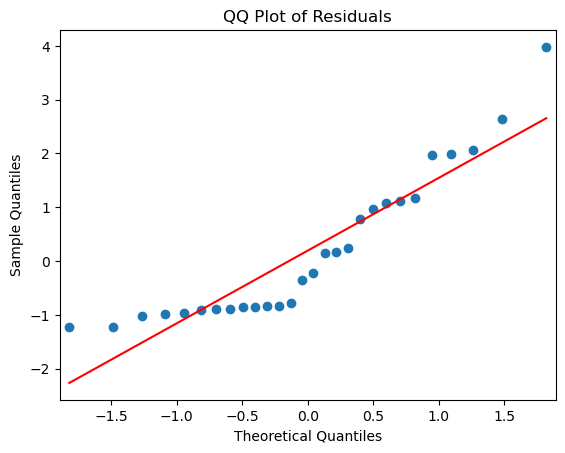

In [126]:
""" As we can see the actual data has more marked peaks. 
    Let's check residuals 

    ACF: as we see we dont have significant lags of resiaduals. And QQ plots looks quite good by showing that sgd model almost capture pattern.
    But our residuals do not have a normal distribution and with a sharp positive skew to the left """


plot_actual_vs_predicted(sales_eval_df, final_predictions_lgb)
analyze_residuals(sales_eval_df, final_predictions_lgb)

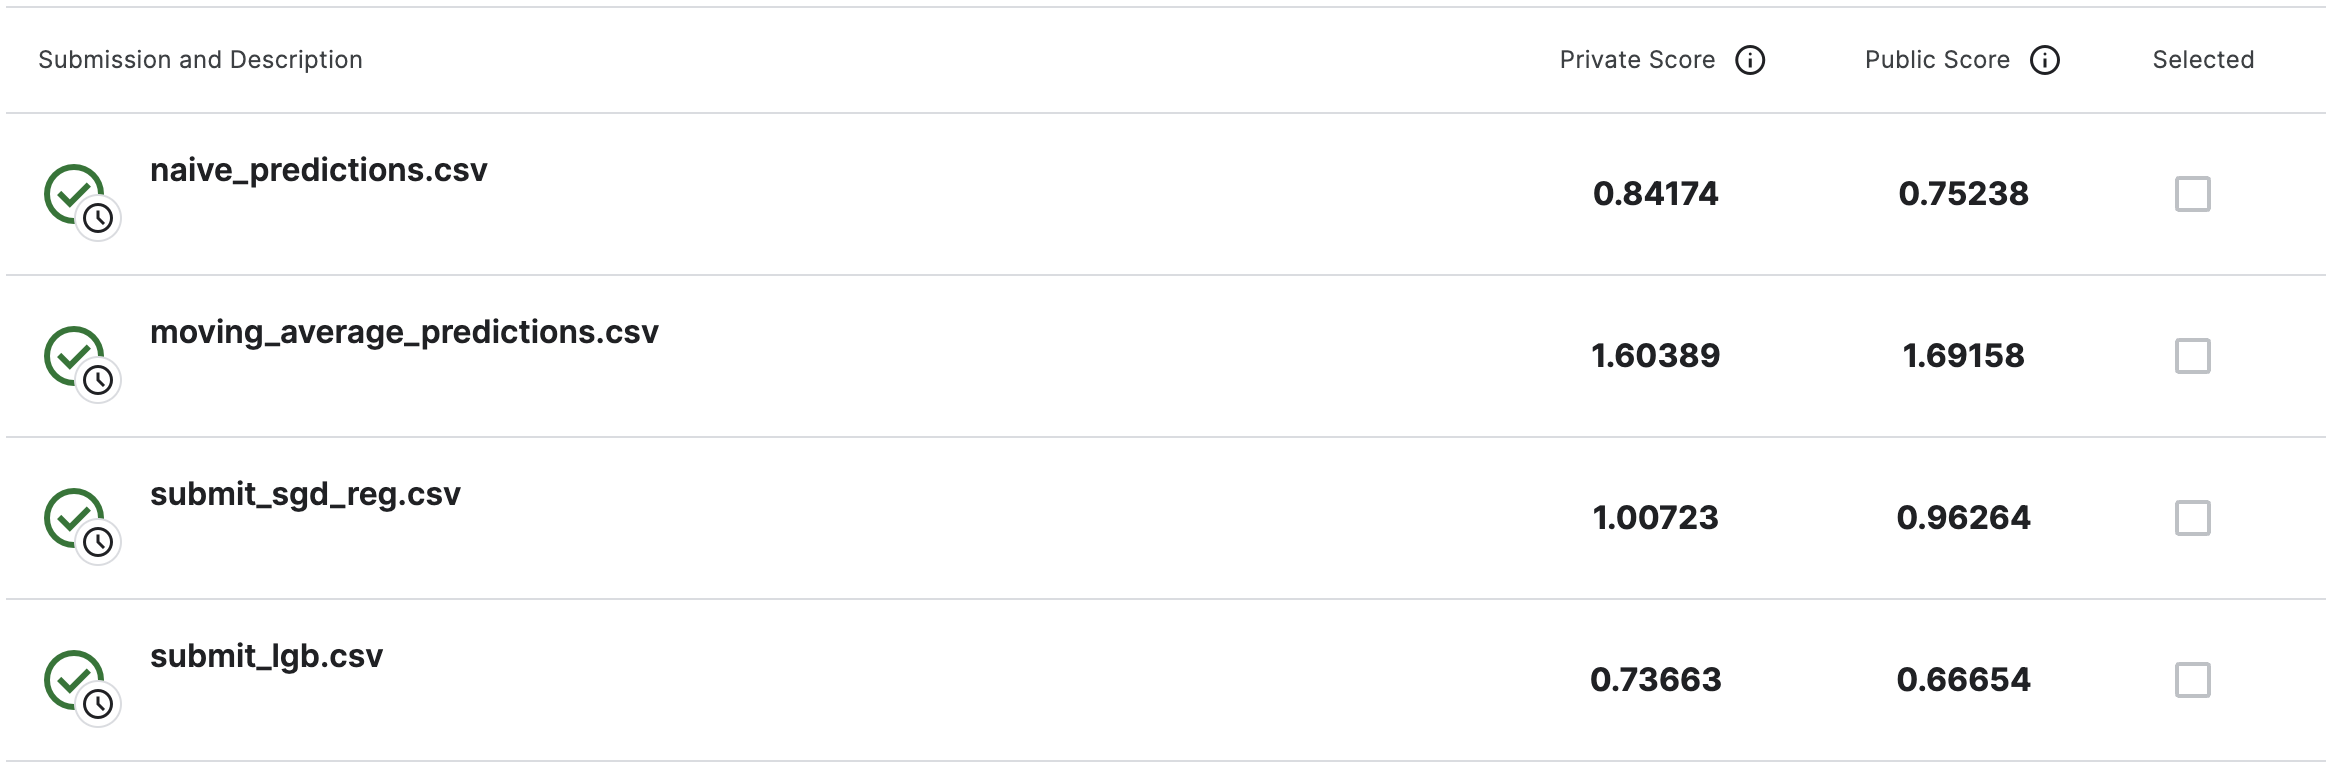

In [86]:
image_path = 'res.png'
Image(filename=image_path)

In [122]:
metrics_df = display_model_metrics(model_metrics)
print(metrics_df)

      Model Name  WRMSSE
0            SGD    0.96
1  LGBMRegressor    0.67
2    Naive model    0.75
3       MA model    1.69


After extensive feature engineering, the dataset now includes:
*Temporal Features:* Lag features such as 'lag_28', 'lag_35', etc., which represent sales values from 28 to 84 days prior on any given day.
*Rolling Statistics:* These include mean ('rolling_mean_7', 'rolling_mean_14', etc.) and median ('rolling_median_7', 'rolling_median_14', etc.) features calculated over varying window sizes (7 to 60 days).
*Calendar Features:* Additional features like 'day_of_month', 'week_no_inmonth', and 'is_weekend' to capture temporal patterns and weekend effects.
Post preprocessing and feature engineering, we implemented time-based data splitting for model training. We evaluated various baseline and machine learning models for sales forecasting and assessed their performance metrics. Notably, naive model models outperformed linear model, with LightGBM boosting achieving the best performance with a low WRMSSE score of 0.67.

After experimenting with various combinations of base-learners and meta-models using the sales data from validation days (1914-1941), where true sales values are available for evaluation, we found that the LGBMRegressor consistently achieved a lower WRMSSE compared to other meta-models. This observation indicates that, among the configurations tested, the LGBMRegressor performs better in terms of accurately predicting sales, as measured by the WRMSSE benchmark. This finding underscores the effectiveness of LightGBM in capturing the complexities of the sales data and generating forecasts that closely match the actual sales figures during the validation period.